# LSTM

In [2]:
import numpy as np
import json
import re
import string

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, utils, optimizers

##0. Parameters

In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
N_UNITS = 128
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 25

##1. Load the data

In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/hugodarwood/epirecipes")

In [ ]:
# Load the full data
with open("epirecipes/full_format_recipes.json") as json_data:
  recipe_data = json.load(json_data)

In [ ]:
# Filter the dataset
filtered_data = [
    'Recipe for ' + x['title']+ ' | ' + ' '.join(x['directions'])
    for x in recipe_data
    if 'title' in x
    and x['title'] is not None
    and 'directions' in x
    and x['directions'] is not None
 ]

In [ ]:
filtered_data[:1]

In [ ]:
# Count the recipes
n_recipes = len(filtered_data)
print(f"{n_recipes} recipes loaded")

In [ ]:
example = filtered_data[9]
example

##2. Tokenise the data

In [ ]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
  s = re.sub(f"([{string.punctuation}])", r" \1 ", s)
  s = re.sub(" +", " ", s)
  return s

text_data = [pad_punctuation(x) for x in filtered_data]

In [ ]:
# Display an example of a recipe
example_data = text_data[9]
example_data

In [ ]:
# Convert to Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

In [ ]:
# Create a vectorization layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1
)

In [ ]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [ ]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
  print(f"{i}: {word}")

In [ ]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
example_tokenised.numpy()

## 3. Create the Training Set

In [ ]:
# Create the training set of recipes and the same text shifted by one word
def prepare_inputs(text): 
  text = tf.expand_dims(text, -1)
  tokenized_sentences = vectorize_layer(text)
  x = tokenized_sentences[:, :-1]
  y = tokenized_sentences[:, 1:]
  return x, y

train_ds = text_ds.map(prepare_inputs)

## 4. Buidld the LSTM

In [ ]:
inputs = layers.Input(shape=(None,), dtype="int32")
x = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
x = layers.LSTM(N_UNITS, return_sequences=True)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
lstm = models.Model(inputs, outputs)
lstm.summary()

## 5. Train the LSTM

In [ ]:
loss_fn = losses.SparseCategoricalCrossentropy()
lstm.compile(optimizer="adam", loss=loss_fn)

In [ ]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
  def __init__(self, index_to_word, top_k=10):
    self.index_to_word = index_to_word
    self.word_to_index = {
        word: index for index, word in enumerate(index_to_word)
    }

  def sample_from(self, probs, temperature):
    probs = probs ** (1 / temperature)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs

  def generate(self, start_prompt, max_tokens, temperature):
    start_tokens = [
        self.word_to_index.get(x, 1) for x in start_prompt.split()
    ]
    sample_token = None
    info = []
    while len(start_tokens) < max_tokens and sample_token != 0:
      x = np.array([start_tokens])
      y = self.model.predict(x, verbose=0)
      sample_token, probs = self.sample_from(y[0][-1], temperature)
      info.append({'prompt': start_prompt, "word_probs": probs})
      start_tokens.append(sample_token)
      start_prompt = start_prompt + " " + self.index_to_word[sample_token] 
    print(f"\ngenerated text:\n{start_prompt}\n")
    return info

  def on_epoch_end(self, epoch, logs=None):
    self.generate("recipe for", max_tokens=100, temperature=1.0)

In [ ]:
# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [ ]:
lstm.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[text_generator]
)

In [ ]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        print(f"\nPROMPT: {i['prompt']}")
        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=150, temperature=1.0
)

In [ ]:
print_probs(info, vocab)

In [ ]:
info = text_generator.generate(
    "recipe for roasted vegetables | chop 1 /", max_tokens=120, temperature=0.2
)

In [ ]:
print_probs(info, vocab)

In [ ]:
info = text_generator.generate(
    "recipe for chocolate ice cream |", max_tokens=100, temperature=0.7
)

In [ ]:
lstm.save("lstm_reregressive")

In [ ]:
lstm_reloaded = models.load_model("/content/lstm_reregressive")

# PixelCNN

In [7]:
!wget https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py

--2023-05-04 03:53:15--  https://raw.githubusercontent.com/davidADSP/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]     771  --.-KB/s    in 0s      

2023-05-04 03:53:15 (37.6 MB/s) - ‘utils.py.1’ saved [771/771]



In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from utils import display

## 0. Parameters

In [9]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 20

## 1. Prepare the data

In [10]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [11]:
# Preprocess the data
def preprocess(imgs_int):
  imgs_int = np.expand_dims(imgs_int, -1)
  imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
  imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
  imgs = imgs_int.astype("float32")
  imgs = imgs / PIXEL_LEVELS
  return imgs, imgs_int

input_data, output_data = preprocess(x_train)

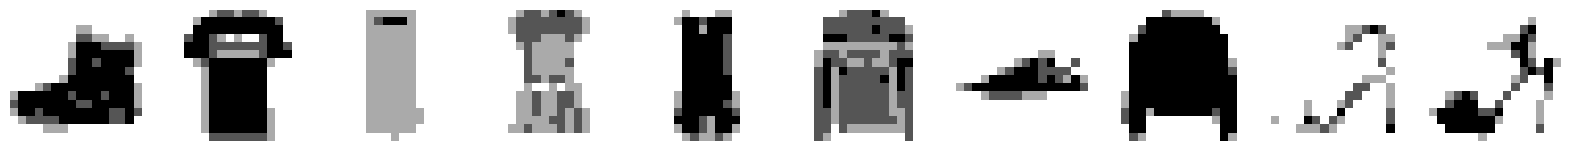

In [12]:
display(input_data)

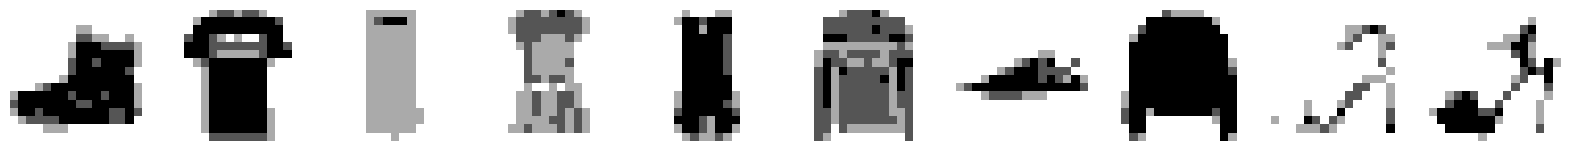

In [13]:
display(output_data)

##2. Build the PixelCNN

In [14]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
  def __init__(self, mask_type, **kwargs):
    super(MaskedConv2D, self).__init__()
    self.mask_type = mask_type
    self.conv = layers.Conv2D(**kwargs)

  def build(self, input_shape):
    # Build the conv2d layer to initialize kernel variables
    self.conv.build(input_shape)
    # Use the initialized kernel to create the mask
    kernel_shape = self.conv.kernel.get_shape()
    self.mask = np.zeros(shape=kernel_shape)
    self.mask[: kernel_shape[0] // 2, ...] = 1.0
    self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
    if self.mask_type == 'B':
      self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

  def call(self, inputs):
    self.conv.kernel.assign(self.conv.kernel * self.mask)
    return self.conv(inputs)

  def get_config(self):
    cfg = super().get_config()
    return cfg


In [18]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [19]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d_2 (MaskedConv  (None, 16, 16, 128)      6400      
 2D)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_3 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                       

In [20]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [21]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.4903

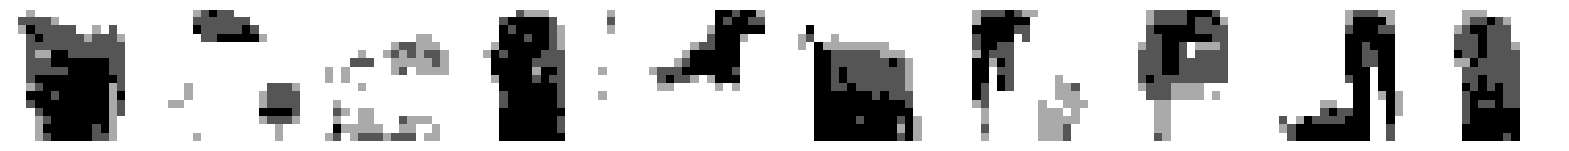

469/469 [==============================] - 45s 63ms/step - loss: 0.4903
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.3992

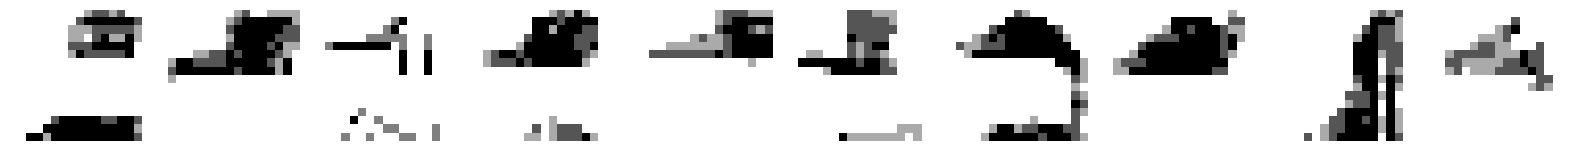

469/469 [==============================] - 30s 63ms/step - loss: 0.3992
Epoch 3/20
468/469 [============================>.] - ETA: 0s - loss: 0.3865

In [ ]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[img_generator_callback],
)

In [ ]:
generated_images = img_generator_callback.generate(temperature=1.0)

In [ ]:
display(generated_images)